In [24]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from keras import callbacks


In [25]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [26]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()


In [27]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)


In [28]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

In [29]:
def final_model(inputs):

    # resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                           

In [30]:
# Record start time
start_time = time.time()
print('Training started at %s', time.ctime(start_time))

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks_def = [ eary_stopping]
EPOCHS = 40
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64, callbacks=callbacks_def)


# Record end time
end_time = time.time()
print('Training ended at %s', time.ctime(end_time))

# Calculate duration of training
duration = end_time - start_time
print('Training duration: %i seconds', int(duration))


Training started at %s Thu May 11 17:52:35 2023
Epoch 1/40
782/782 [==============================] - 53s 48ms/step - loss: 1.1574 - accuracy: 0.5966 - val_loss: 0.8063 - val_accuracy: 0.7231
Epoch 2/40
782/782 [==============================] - 36s 46ms/step - loss: 0.6528 - accuracy: 0.7754 - val_loss: 0.6850 - val_accuracy: 0.7675
Epoch 3/40
782/782 [==============================] - 36s 46ms/step - loss: 0.4609 - accuracy: 0.8395 - val_loss: 0.6803 - val_accuracy: 0.7718
Epoch 4/40
782/782 [==============================] - 36s 46ms/step - loss: 0.3323 - accuracy: 0.8856 - val_loss: 0.6765 - val_accuracy: 0.7837
Epoch 5/40
782/782 [==============================] - 35s 45ms/step - loss: 0.2372 - accuracy: 0.9190 - val_loss: 0.7134 - val_accuracy: 0.7888
Epoch 6/40
782/782 [==============================] - 35s 45ms/step - loss: 0.1702 - accuracy: 0.9421 - val_loss: 0.8329 - val_accuracy: 0.7793
Epoch 7/40
782/782 [==============================] - 35s 45ms/step - loss: 0.1349 - acc

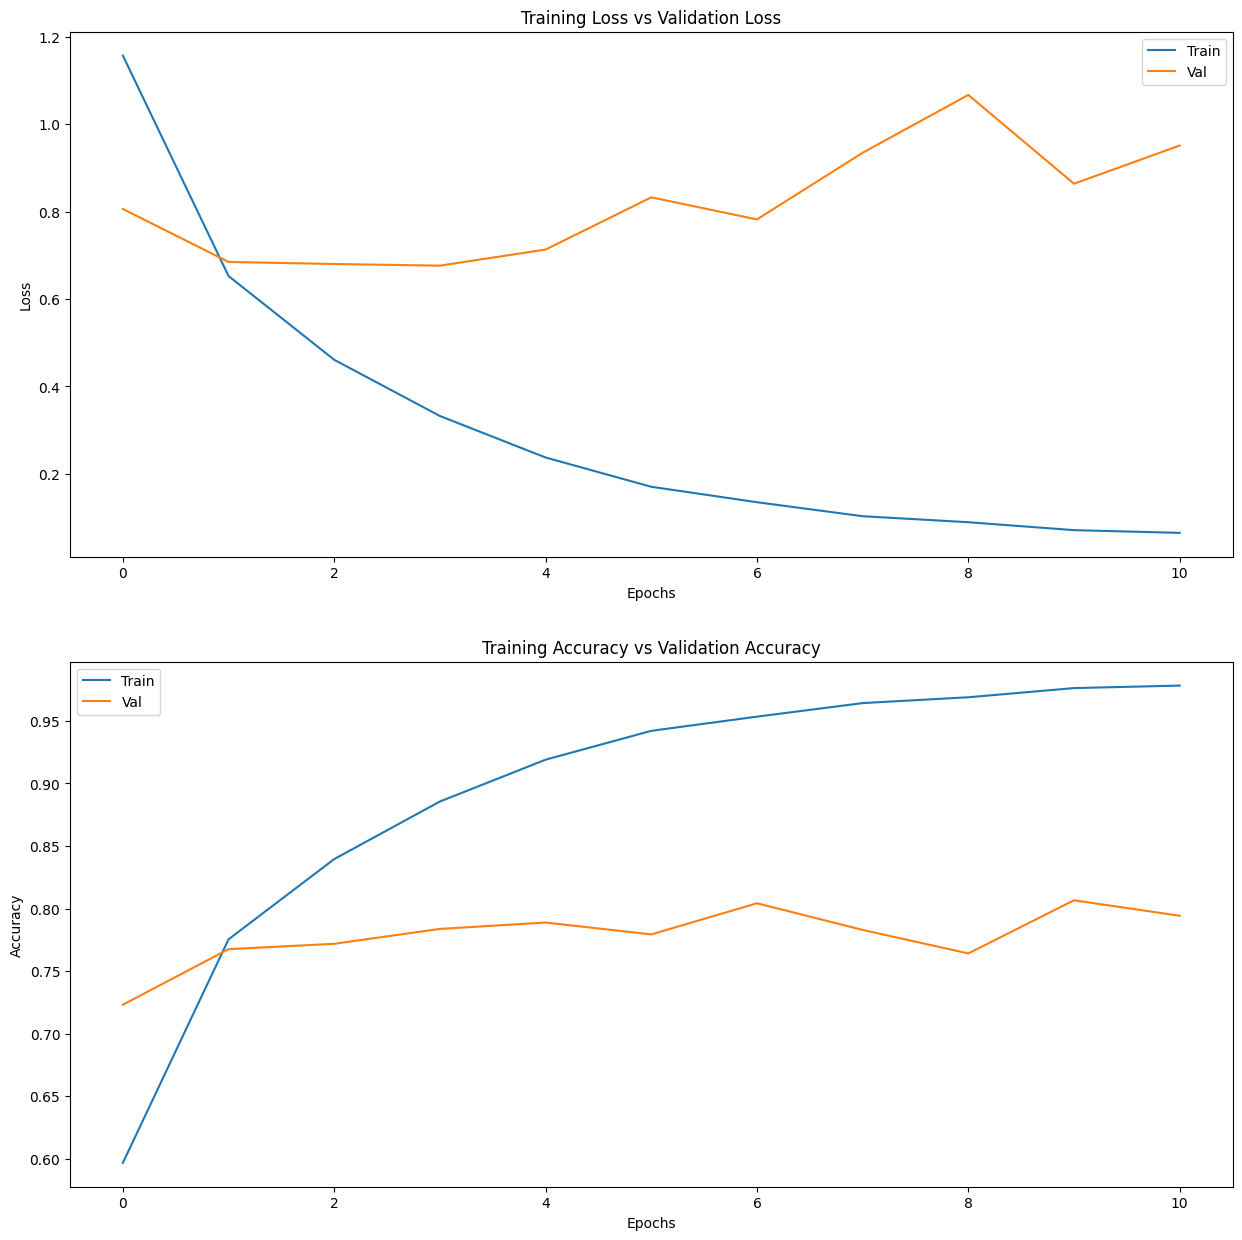

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [32]:
model.evaluate(valid_X, validation_labels)

313/313 [==============================] - 3s 11ms/step - loss: 0.9515 - accuracy: 0.7942


[0.9514779448509216, 0.7942000031471252]